# Show true demand if ED/SDEC are meeting 4-hour targets (experimental notebook - WORK IN PROGRESS)

UCLH were interested in what the true demand for beds would be, given typical patterns of arrival rates at the ED/SDEC front door by patients who went on to be admitted, and assuming these patients were moved through the ED and SDEC into beds in a timely manner. By 'timely manner', they mean that the ED/SDEC were meeting the 4-hour targets set by NHS England. 

UCLH stakeholders wanted this analysis to help them communicate to colleagues on the wards about what the wards would need to do to support meeting of ED targets, by making beds available in time. 

There is a mismatch of cadence in many hospitals, whereby people arrive earlier in the day than beds are ready, so my expectation was that I'd see a majority of beds needed earlier in the day. In fact, this analysis, shown in the figures below, revealed how many beds were needed over night. 

Please note - this is work in progress. 

## Set up the notebook environment

In [1]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

In [2]:
from pathlib import Path
import sys
import json
import pandas as pd

root = Path().resolve().parent

sys.path.append(str(root.parent/ 'src' / 'patientflow'))


In [72]:
# indicate whether the notebook is being run locally for UCLH or with public datasets
uclh = False
from patientflow.load import set_file_paths
from patientflow.load import load_config_file


# set file location
if uclh:
    data_file_path, media_file_path, model_file_path, config_path = set_file_paths(
        train_dttm = None, data_folder_name = 'data-uclh', uclh = uclh, from_notebook=True
    )
else:
     data_file_path, media_file_path, model_file_path, config_path = set_file_paths(
        train_dttm = None, data_folder_name = 'data-public', uclh = uclh, from_notebook=True
    )   


# load params
params = load_config_file(config_path)

prediction_times = params["prediction_times"]
start_training_set, start_validation_set, start_test_set, end_test_set = params["start_training_set"], params["start_validation_set"], params["start_test_set"], params["end_test_set"]
x1, y1, x2, y2 = params["x1"], params["y1"], params["x2"], params["y2"]
prediction_window = params["prediction_window"]
epsilon = float(params["epsilon"])
yta_time_interval = params["yta_time_interval"]

## Load data

In [19]:
import pandas as pd
from patientflow.load import set_data_file_names

if uclh:

    visits_path, visits_csv_path, yta_path, yta_csv_path = set_data_file_names(uclh, data_file_path, config_path)
else:
    visits_csv_path, yta_csv_path = set_data_file_names(uclh, data_file_path)

yta = pd.read_csv(yta_csv_path)

yta['arrival_datetime'] = pd.to_datetime(yta['arrival_datetime'], utc = True)

weekdays_yta = yta[yta['arrival_datetime'].dt.weekday < 5] 

yta.set_index('arrival_datetime', inplace=True)
weekdays_yta.set_index('arrival_datetime', inplace=True)


## Separate into training, validation and test sets

As part of preparing the data, each visit has already been allocated into one of three sets - training, vaidation and test sets. 

In [20]:
def get_training_set(yta):


    train_yta = yta[yta.training_validation_test == 'train']
    valid_yta = yta[yta.training_validation_test == 'valid']
    test_yta = yta[yta.training_validation_test == 'test']

    return (train_yta, valid_yta, test_yta)

train_yta, valid_yta, test_yta = get_training_set(weekdays_yta)

## Get arrival rates by hour

In [23]:
from patientflow.prepare import calculate_time_varying_arrival_rates
dict_ = calculate_time_varying_arrival_rates(train_yta, yta_time_interval = 60)

Calculating time-varying arrival rates for data provided, which spans 130 unique dates


In [24]:
train_yta

,training_validation_test,sex,specialty,is_child
arrival_datetime,,,,
2031-04-24 19:21:00+00:00,train,M,haem/onc,False
2031-04-25 12:42:00+00:00,train,F,medical,False
2031-03-20 19:54:00+00:00,train,F,haem/onc,False
2031-03-04 22:03:00+00:00,train,F,haem/onc,False
2031-03-03 08:13:00+00:00,train,M,NaN,False
...,...,...,...,...
2031-08-29 23:29:25+00:00,train,F,medical,False
2031-04-23 03:03:00+00:00,train,M,NaN,False
2031-08-11 03:45:32+00:00,train,M,NaN,False


In [26]:
import datetime
from collections import OrderedDict

def get_arrival_rates(train_yta, time_interval = 60):

    # spec_dict

    # for _spec in ['medical', 'surgical', 'haem/onc', 'paediatric']:
    df = train_yta.copy()
    dict_ = calculate_time_varying_arrival_rates(df, time_interval)

    # Extract keys and values
    hours = list(dict_.keys())
    arrival_rates = list(dict_.values())
    
    # Lag the arrival times by 4 hours
    lagged_dict = OrderedDict()
    for time, rate in dict_.items():
        lagged_time = (datetime.datetime.combine(datetime.date.today(), time) + datetime.timedelta(hours=4)).time()
        lagged_dict[lagged_time] = rate

    sorted_lagged_dict = OrderedDict(sorted(lagged_dict.items()))
    arrival_rates_lagged = list(sorted_lagged_dict.values())

    return (hours, arrival_rates, arrival_rates_lagged)




In [27]:
hours, arrival_rates, arrival_rates_lagged = get_arrival_rates(train_yta, time_interval = 60)

hour_labels = [f'{hour.strftime("%H")}-\n{str((hour.hour + 1) % 24).zfill(2)} 'for hour in hours]
hour_values = list(range(len(hour_labels)))

# Calculate a tiny margin for the x-axis
x_margin = 0.5  # Adjust this value as needed for a tiny margin

line_styles = {12: '--', 17 : ':'}

Calculating time-varying arrival rates for data provided, which spans 130 unique dates


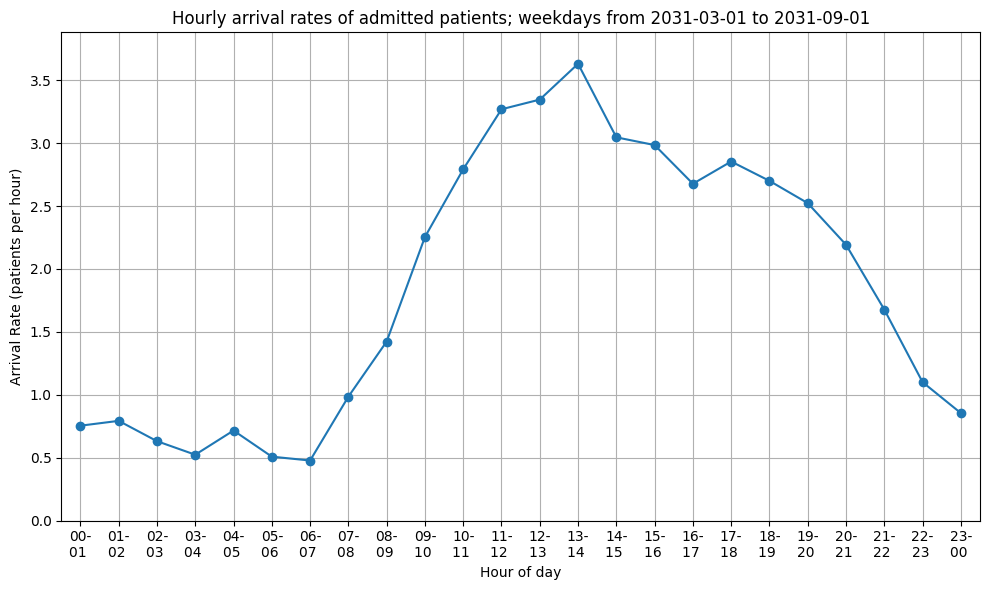

In [29]:
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta


n = 0
# hour_labels = [f'{hour.strftime("%H:%M")}-{str((hour.hour + 1) % 24).zfill(2)}:00'for hour in hours]
title = f'Hourly arrival rates of admitted patients; weekdays from {start_training_set - timedelta(days=n*7)} to {start_validation_set - timedelta(days=n*7)}'

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(hour_labels, arrival_rates, marker='o')
# plt.xticks(rotation=45)
plt.ylim(0, max(arrival_rates) + .25)
plt.xlim(hour_values[0] - x_margin, hour_values[-1] + x_margin)

plt.xlabel('Hour of day')
plt.ylabel('Arrival Rate (patients per hour)')
plt.title(title)
plt.grid(True)
plt.tight_layout()
plt.savefig(media_file_path / title.replace(" ", "_"), dpi=300)
plt.show()

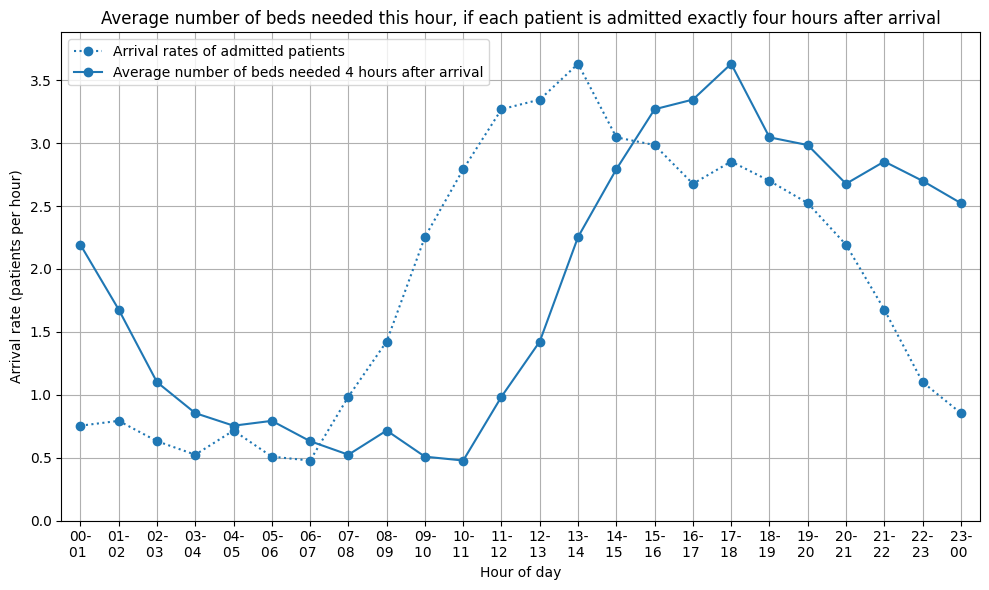

In [30]:




title = 'Average number of beds needed this hour, if each patient is admitted exactly four hours after arrival'

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(hour_labels, arrival_rates, marker='o', linestyle=':', label='Arrival rates of admitted patients')
plt.plot(hour_labels, arrival_rates_lagged, marker='o', color='C0', label='Average number of beds needed 4 hours after arrival')
plt.legend()
plt.ylim(0, max(arrival_rates) + .25)
plt.xlim(hour_values[0] - x_margin, hour_values[-1] + x_margin)

# plt.xticks(rotation=45)
plt.xlabel('Hour of day')
plt.ylabel('Arrival rate (patients per hour)')
plt.title(title)
plt.grid(True)
plt.tight_layout()
plt.savefig(media_file_path / title.replace(" ", "_"), dpi=300)

plt.show()

In [31]:
cumulative_arrivals_lagged[12]

NameError: name 'cumulative_arrivals_lagged' is not defined

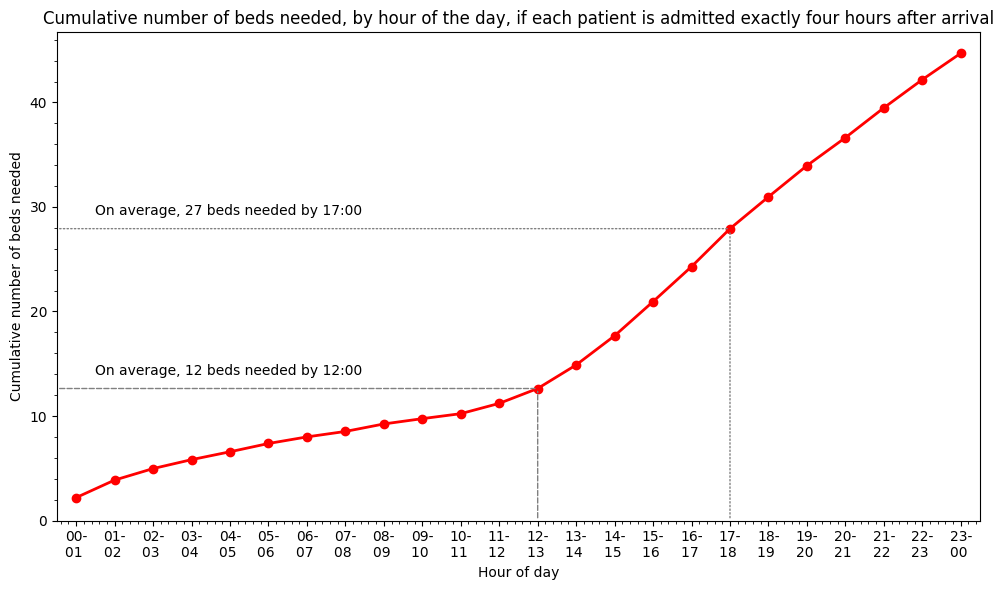

In [32]:
# Cumulative arrival rates
import numpy as np

# Calculate cumulative arrivals
# total_arrivals = np.sum(arrival_rates)
cumulative_arrivals_lagged = (np.cumsum(arrival_rates_lagged) )
title = 'Cumulative number of beds needed, by hour of the day, if each patient is admitted exactly four hours after arrival'
# Plot the cumulative data
plt.figure(figsize=(10, 6))
plt.plot(hour_labels, cumulative_arrivals_lagged, marker='o', color='red', linewidth=2)

# plt.xticks(rotation=45)
plt.xlabel('Hour of day')
plt.ylabel('Cumulative number of beds needed')
plt.ylim(0, max(cumulative_arrivals_lagged) + 2)
plt.xlim(hour_values[0] - x_margin, hour_values[-1] + x_margin)
plt.minorticks_on()
plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(2))


for hour_line in [12,17]:
    plt.annotate('', xy=(hour_values[hour_line], cumulative_arrivals_lagged[hour_line]), xytext=(hour_values[hour_line], 0),
                arrowprops=dict(arrowstyle='-', linestyle=line_styles[hour_line], color='grey'))
    plt.annotate('', xy=(hour_values[hour_line], cumulative_arrivals_lagged[hour_line]), xytext=(hour_values[0] - x_margin, cumulative_arrivals_lagged[hour_line]),
                arrowprops=dict(arrowstyle='-', linestyle=line_styles[hour_line], color='grey'))

for hour_line in [12, 17]:
    # plt.plot([], [], linestyle=line_styles[hour_line], color='grey', label=f'Number of beds needed by {hour_line}:00')
    # plt.grid(True)
    plt.annotate(f'On average, {int(cumulative_arrivals_lagged[hour_line])} beds needed by {hour_line}:00', xy=(hour_values[hour_line], cumulative_arrivals_lagged[hour_line]), xytext=(hour_values[1] - x_margin, cumulative_arrivals_lagged[hour_line] + 1
                                                                                                                                                                            ),
                ha='left', va='bottom', fontsize=10)

plt.title(title)
# plt.legend(loc='upper left')

plt.tight_layout()
plt.savefig(media_file_path / title.replace(" ", "_"), dpi=300)

plt.show()

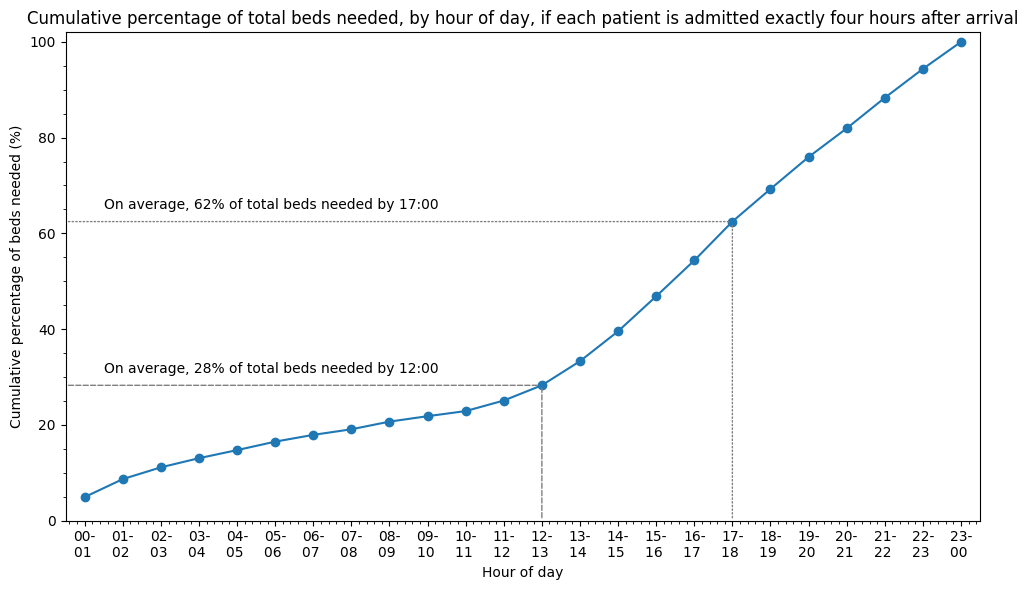

In [33]:
# Cumulative arrival rates - percentages
import numpy as np

# Calculate cumulative arrivals
total_arrivals = np.sum(arrival_rates)
cumulative_arrivals_percentage = (np.cumsum(arrival_rates_lagged) / total_arrivals) * 100

title = 'Cumulative percentage of total beds needed, by hour of day, if each patient is admitted exactly four hours after arrival'
# Plot the cumulative data
plt.figure(figsize=(10, 6))
plt.plot(hour_labels, cumulative_arrivals_percentage, marker='o')
# plt.xticks(rotation=45)
plt.xlabel('Hour of day')
plt.ylabel('Cumulative percentage of beds needed (%)')
plt.ylim(0, 100 + 2)
plt.xlim(hour_values[0] - x_margin, hour_values[-1] + x_margin)
plt.minorticks_on()
plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(5))



for hour_line in [12,17]:
    plt.annotate('', xy=(hour_values[hour_line], cumulative_arrivals_percentage[hour_line]), xytext=(hour_values[hour_line], 0),
                arrowprops=dict(arrowstyle='-', linestyle=line_styles[hour_line], color='grey'))
    plt.annotate('', xy=(hour_values[hour_line], cumulative_arrivals_percentage[hour_line]), xytext=(hour_values[0] - x_margin, cumulative_arrivals_percentage[hour_line]),
                arrowprops=dict(arrowstyle='-', linestyle=line_styles[hour_line], color='grey'))

for hour_line in [12, 17]:
    # plt.plot([], [], linestyle=line_styles[hour_line], color='grey', label=f'Percentage of beds needed by {hour_line}:00')

    plt.annotate(f'On average, {int(cumulative_arrivals_percentage[hour_line])}% of total beds needed by {hour_line}:00', xy=(hour_values[hour_line], cumulative_arrivals_percentage[hour_line]), xytext=(hour_values[1] - x_margin, cumulative_arrivals_percentage[hour_line] + 2),
                    ha='left', va='bottom', fontsize=10)

plt.title(title)
# plt.grid(True)
plt.tight_layout()
# plt.legend(loc='upper left')

plt.savefig(media_file_path / title.replace(" ", "_"), dpi=300)

plt.show()

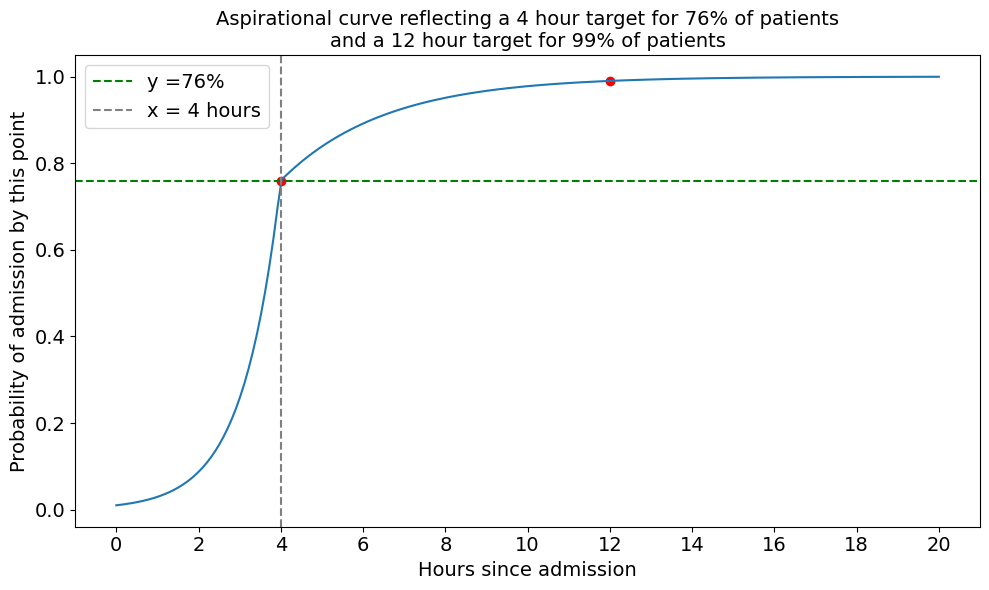

In [35]:
from patientflow.viz.aspirational_curve_plot import plot_curve

figsize = (6,3)
title = 'Aspirational curve reflecting a ' + str(int(x1)) + ' hour target for ' + str(int(y1*100)) + \
        '% of patients\nand a '+ str(int(x2)) + ' hour target for ' + str(int(y2*100)) + '% of patients'

plot_curve(
    title = title,
    x1 = x1,
    y1 = y1,
    x2 = x2,
    y2 = y2,
    figsize = (10,6),
    include_titles=True,
    text_size=14,
    directory_path=media_file_path,
    file_name=title.replace(" ", "_"),
)


## For each hour after arrival, calculate the probability of being admitted in that hour if ED is performing according to targets

In [39]:
max_hours_since_arrival = 12
hours_since_arrival = np.arange(max_hours_since_arrival + 1)

from patientflow.predict.admission_in_prediction_window import get_y_from_aspirational_curve
prob_admission_by_this_hour = []
for i in range(len(hours_since_arrival)):
    prob = get_y_from_aspirational_curve(hours_since_arrival[i], x1, y1, x2, y2)
    prob_admission_by_this_hour.append(prob)
prob_admission_by_this_hour = np.array(prob_admission_by_this_hour)
prob_admission_by_this_hour

prob_admission_within_this_hour = np.diff(prob_admission_by_this_hour)
prob_admission_within_this_hour

array([0.01952592, 0.05765206, 0.170223  , 0.50259902, 0.07868125,
       0.05288651, 0.03554827, 0.02389418, 0.01606074, 0.01079541,
       0.00725626, 0.00487738])

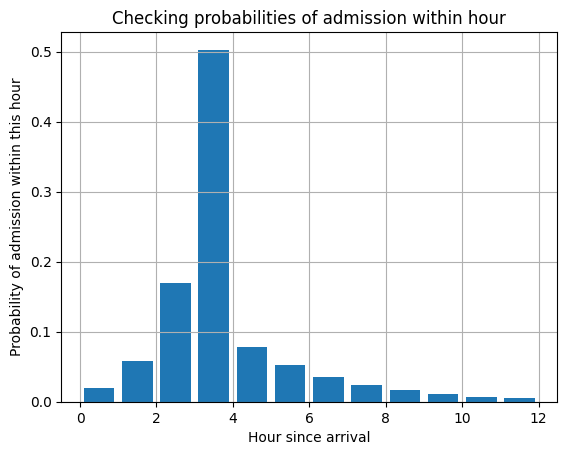

In [40]:
# plot these to check they are what we'd expect
plt.bar(np.arange(len(prob_admission_within_this_hour)) + 0.5, prob_admission_within_this_hour) # shifting bars to the left to portray the probability of admission within the hour
plt.xlabel('Hour since arrival')
plt.ylabel('Probability of admission within this hour')
plt.title('Checking probabilities of admission within hour')
plt.grid()
plt.show()

## True demand by hour

In [42]:
from patientflow.prepare import calculate_time_varying_arrival_rates
poisson_means_dict = calculate_time_varying_arrival_rates(train_yta, yta_time_interval = 60)
poisson_means = np.array(list(poisson_means_dict.values()))

Calculating time-varying arrival rates for data provided, which spans 130 unique dates


In [43]:
# poisson mean at hour zero
poisson_means

array([0.75384615, 0.79230769, 0.63076923, 0.52307692, 0.71538462,
       0.50769231, 0.47692308, 0.98461538, 1.42307692, 2.25384615,
       2.79230769, 3.26923077, 3.34615385, 3.63076923, 3.04615385,
       2.98461538, 2.67692308, 2.85384615, 2.7       , 2.52307692,
       2.19230769, 1.67692308, 1.1       , 0.85384615])

At hour zero, we have 0.75 arrivals on average, with a probability of this of being admitted within the hour between midnight and 1 am

In [44]:
# Probability of admission in first hour
prob_admission_within_this_hour

array([0.01952592, 0.05765206, 0.170223  , 0.50259902, 0.07868125,
       0.05288651, 0.03554827, 0.02389418, 0.01606074, 0.01079541,
       0.00725626, 0.00487738])

We can multiply these to get a average number of patients who arrived and were admitted over the hour between midnight and 1 am 

In [45]:
# Average number of patients arriving between 0 and 1 hours, admitted between 0 and 1 if ED hitting targets
poisson_means[0] * prob_admission_within_this_hour[0]

0.014719537609711116

Similarly we can get an average number of patients who arrived between midnight and 1 am and were admitted between 3 am and 4 am

In [46]:
# Average number of patients arriving between 0 and 1 hours, admitted between 3 and 4 hours, if ED hitting targets
# Probability of admission in fourth hour
poisson_means[0] * prob_admission_within_this_hour[3]

0.37888233897847895

This code sets up a 2D array called poisson_means_all with dimensions (max_hours_since_arrival, 24, where:

* The first dimension represents the hour since arrival (0 to 11).
* The second dimension holds the Poisson means for arrival rates within each hour after arrival, weighted by the probability of admission within that hour. This has length 24 for each hour in the day
  
Access the Poisson mean for any specific hour of the day, and hour after arrival using poisson_means_all[hour, i].

In [47]:
# Create an empty array to hold a Poisson distribution for each hour of the day, up to an arbitrary maximum number of arrivals in that hour
from scipy.stats import poisson
max_hours_since_arrival = 10
# Initialize a 3D array to hold all distributions across all hours



In [48]:
poisson_means_all = np.zeros((max_hours_since_arrival, len(poisson_means)))

for hour_of_day in range(0,24):
    arrival_rate = poisson_means[hour_of_day]
    for elapsed_hour_since_arrival in range(0, max_hours_since_arrival):
        weighted_arrival_rate = arrival_rate*prob_admission_within_this_hour[elapsed_hour_since_arrival]
        poisson_means_all[elapsed_hour_since_arrival][hour_of_day] = weighted_arrival_rate



In [49]:
# this holds the weighted arrival rates for patients admitted within the first hour of arrival, for each hour of the day
poisson_means_all[0]

array([0.01471954, 0.01547053, 0.01231635, 0.01021356, 0.01396854,
       0.00991316, 0.00931236, 0.01922552, 0.02778688, 0.04400841,
       0.05452237, 0.06383473, 0.06533672, 0.0708941 , 0.05947895,
       0.05827735, 0.05226938, 0.05572396, 0.05271998, 0.04926539,
       0.04280682, 0.03274346, 0.02147851, 0.01667213])

In [50]:
# this holds the weighted arrival rates for patients admitted within the fourth hour of arrival, for each hour of the day
poisson_means_all[3]

array([0.37888234, 0.39821307, 0.317024  , 0.26289795, 0.35955161,
       0.25516566, 0.23970107, 0.49486673, 0.71523707, 1.13278087,
       1.40341111, 1.64311218, 1.68177365, 1.82482106, 1.53099394,
       1.50006477, 1.34541892, 1.43434028, 1.35701736, 1.26809599,
       1.1018517 , 0.8428199 , 0.55285892, 0.42914224])

For arrivals in the 23rd hour of the day, here are the arrival rates for each of the following 10 hours

In [51]:
for elapsed_hour_since_arrival in range(0, max_hours_since_arrival):
    print(poisson_means_all[elapsed_hour_since_arrival][23])

0.016672129333448305
0.049225991087015496
0.1453442538762826
0.42914224108786897
0.06718168639099283
0.04515693908529069
0.030352753214394686
0.02040195031717827
0.013713404309801109
0.00921762159207531


So to get all of the admissions at 3 am for patients in that hour and the preceding five hours, we need 

In [52]:
total_admissions = poisson_means_all[0][3] + \
                  poisson_means_all[1][2] + \
                  poisson_means_all[2][1] + \
                  poisson_means_all[3][0] + \
                  poisson_means_all[4][23] + \
                  poisson_means_all[5][22]
total_admissions



0.6856868767412144

In [53]:
def calculate_sum(poisson_means_all, elapsed_hour_since_arrival, hour_of_day):
    total_sum = 0
    for i in range(len(elapsed_hour_since_arrival)):
        hour_index = (hour_of_day - elapsed_hour_since_arrival[i]) % 24
        total_sum += poisson_means_all[elapsed_hour_since_arrival[i]][hour_index]
    return total_sum

# # Example usage:
# poisson_means_all = [
#     [0] * 24, [0] * 24, [0] * 24, [0] * 24, [0] * 24, [0] * 24
# ]
# # Populate poisson_means_all with example data
# poisson_means_all[0][3] = 5
# poisson_means_all[1][2] = 10
# poisson_means_all[2][1] = 15
# poisson_means_all[3][0] = 20
# poisson_means_all[4][23] = 25
# poisson_means_all[5][22] = 30

elapsed_hour_since_arrival = range(0, 6)
hour_of_day = 3  # Example current hour of the day

result = calculate_sum(poisson_means_all, elapsed_hour_since_arrival, hour_of_day)
print(result)  # Output should be 105

0.6856868767412144


Now let's add a third dimension

In [54]:
def calculate_sum_of_weighted_arrival_rates(poisson_means_all, elapsed_hour_since_arrival, hour_of_day):
    total_sum = 0
    for i in range(len(elapsed_hour_since_arrival)):
        hour_index = (hour_of_day - elapsed_hour_since_arrival[i]) % 24
        total_sum += poisson_means_all[elapsed_hour_since_arrival[i]][hour_index]
    return total_sum

# Initialize a 3D array to hold all summed poisson means across all hours
poisson_means_sum = np.zeros(len(poisson_means))
elapsed_hour_since_arrival = range(0, max_hours_since_arrival)

for hour_of_day in range(0,24):
    sum_arrival_rates = calculate_sum_of_weighted_arrival_rates(poisson_means_all, elapsed_hour_since_arrival, hour_of_day)
    poisson_means_sum[hour_of_day] = sum_arrival_rates

arrival_rates_spread = poisson_means_sum

In [55]:
poisson_means_sum

array([1.63932513, 1.23395907, 1.00308674, 0.86735208, 0.79579955,
       0.66666417, 0.5977566 , 0.63897522, 0.56753124, 0.66566637,
       1.04255646, 1.47675564, 2.07217394, 2.538587  , 2.90766011,
       3.07369687, 3.19046339, 2.94623462, 2.87092593, 2.72374039,
       2.73475348, 2.58507412, 2.37739716, 2.05493619])

### Combine in one function

In [58]:
from scipy.stats import poisson
from patientflow.prepare import calculate_time_varying_arrival_rates

# def calculate_sum(poisson_means_all, elapsed_hour_since_arrival, hour_of_day):
#     total_sum = 0
#     for i in range(len(elapsed_hour_since_arrival)):
#         hour_index = (hour_of_day - elapsed_hour_since_arrival[i]) % 24
#         total_sum += poisson_means_all[elapsed_hour_since_arrival[i]][hour_index]
#     return total_sum

def calculate_sum_of_weighted_arrival_rates(poisson_means_all, elapsed_hour_since_arrival, hour_of_day):
    total_sum = 0
    for i in range(len(elapsed_hour_since_arrival)):
        hour_index = (hour_of_day - elapsed_hour_since_arrival[i]) % 24
        total_sum += poisson_means_all[elapsed_hour_since_arrival[i]][hour_index]
    return total_sum


def get_true_demand_by_hour(train_yta, time_interval = 60, max_hours_since_arrival = 10):

    poisson_means_dict = calculate_time_varying_arrival_rates(train_yta, yta_time_interval = 60)
    poisson_means = np.array(list(poisson_means_dict.values()))

    poisson_means_all = np.zeros((max_hours_since_arrival, len(poisson_means)))
    for hour_of_day in range(0,24):
        arrival_rate = poisson_means[hour_of_day]
        for elapsed_hour_since_arrival in range(0, max_hours_since_arrival):
            weighted_arrival_rate = arrival_rate*prob_admission_within_this_hour[elapsed_hour_since_arrival]
            poisson_means_all[elapsed_hour_since_arrival][hour_of_day] = weighted_arrival_rate
    

    # Initialize a 3D array to hold all summed poisson means across all hours
    poisson_means_sum = np.zeros(len(poisson_means))
    elapsed_hour_since_arrival = range(0, max_hours_since_arrival)
    
    for hour_of_day in range(0,24):
        sum_arrival_rates = calculate_sum_of_weighted_arrival_rates(poisson_means_all, elapsed_hour_since_arrival, hour_of_day)
        poisson_means_sum[hour_of_day] = sum_arrival_rates

    return(poisson_means_sum)
    
arrival_rates_spread___ = get_true_demand_by_hour(train_yta)

Calculating time-varying arrival rates for data provided, which spans 130 unique dates


In [59]:
arrival_rates_spread

array([1.63932513, 1.23395907, 1.00308674, 0.86735208, 0.79579955,
       0.66666417, 0.5977566 , 0.63897522, 0.56753124, 0.66566637,
       1.04255646, 1.47675564, 2.07217394, 2.538587  , 2.90766011,
       3.07369687, 3.19046339, 2.94623462, 2.87092593, 2.72374039,
       2.73475348, 2.58507412, 2.37739716, 2.05493619])

## Plot against arrival rates 

In [60]:
start_training_set 

datetime.date(2031, 3, 1)

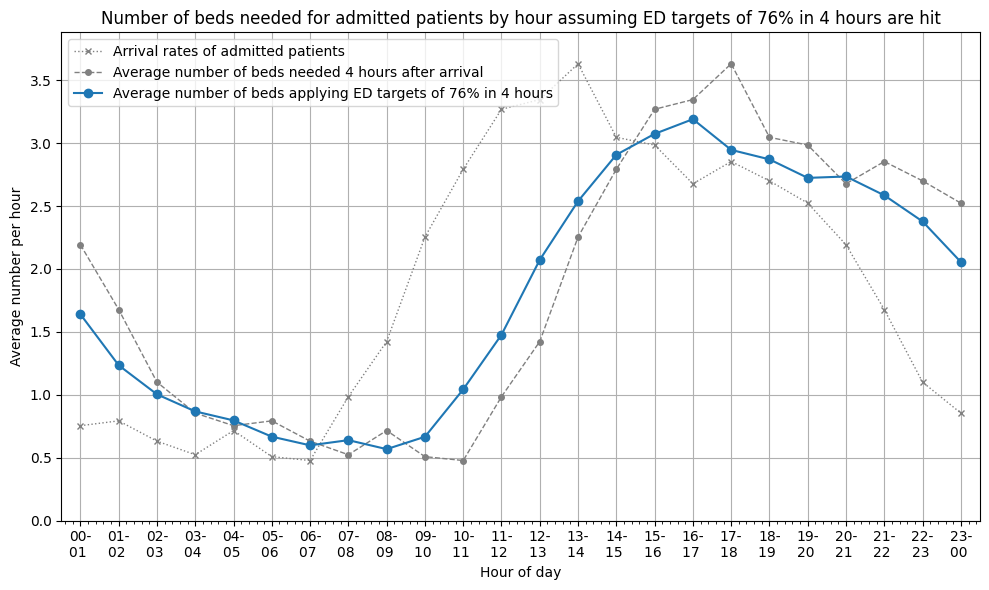

In [61]:

title = f'Number of beds needed for admitted patients by hour assuming ED targets of {int(y1*100)}% in {int(x1)} hours are hit'


# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(hour_labels, arrival_rates, marker='x', color = 'grey',markersize = 4, linestyle=':', linewidth=1, label='Arrival rates of admitted patients')
plt.plot(hour_labels, arrival_rates_lagged, marker='o', markersize = 4, color='grey', linestyle='--', linewidth=1, label='Average number of beds needed 4 hours after arrival')
plt.plot(hour_labels, arrival_rates_spread, marker='o', label=f'Average number of beds applying ED targets of {int(y1*100)}% in {int(x1)} hours')
plt.legend()
plt.ylim(0, max(arrival_rates) + .25)
plt.xlim(hour_values[0] - x_margin, hour_values[-1] + x_margin)
plt.minorticks_on()
plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(5))

plt.legend(loc='upper left')




# plt.xticks(rotation=45)
plt.xlabel('Hour of day')
plt.ylabel('Average number per hour')
plt.title(title)
plt.grid(True)
plt.tight_layout()
plt.savefig(media_file_path / title.replace(" ", "_"), dpi=300)

plt.show()

In [62]:
sum(arrival_rates_spread)

43.27107148964642

In [63]:
np.cumsum(arrival_rates_spread) 

array([ 1.63932513,  2.8732842 ,  3.87637094,  4.74372302,  5.53952257,
        6.20618674,  6.80394335,  7.44291857,  8.0104498 ,  8.67611617,
        9.71867264, 11.19542828, 13.26760222, 15.80618923, 18.71384934,
       21.78754621, 24.9780096 , 27.92424422, 30.79517016, 33.51891054,
       36.25366403, 38.83873814, 41.2161353 , 43.27107149])

In [65]:
from numpy import cumsum
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

def plot_final(poisson_means_sum, title, 
               highlight_centile = .9, 
               centiles = [0.3, 0.5, 0.7, 0.9, 0.99], 
               markers = ['D', 's', '^', 'o', 'v'],
               line_style = '-',
                line_styles = {12: '--', 17 : ':'},
                line_styles_centiles = ['-.', '--', ':', '-', '-'],
              _spec = ''):

    
    percentiles = [[] for _ in range(len(centiles))]
    cumulative_value_at_centile = np.zeros(len(centiles))
    
    for hour_of_day in range(0, len(poisson_means_sum)):
        for i in range(0,len(centiles)):
            value_at_centile = stats.poisson.ppf(centiles[i], poisson_means_sum[hour_of_day])
            cumulative_value_at_centile[i] += value_at_centile
            percentiles[i].append(value_at_centile)
    
    # Plot each percentile array
    plt.figure(figsize=(10, 6))
    
    # Define a list of markers and line styles

    
    plt.plot(hour_labels, np.cumsum(poisson_means_sum), marker='o', markersize = 3, linestyle=line_style, color='C0', linewidth=1, alpha=0.7, label=f'Average number of {_spec} beds needed') 
    
    # Plot each line with different properties, emphasizing the 50% line
    for i in range(len(centiles)):
        marker = markers[i % len(markers)]
        line_style = line_styles_centiles[i % len(line_styles_centiles)]
        if centiles[i] == highlight_centile:
            plt.plot(hour_labels, np.cumsum(percentiles[i]), marker=marker, linestyle=line_style, color='red', linewidth=2, label=f'{centiles[i]*100:.0f}% probability')
            for hour_line in [12,17]:
                plt.annotate('', xy=(hour_values[hour_line], sum(percentiles[i][0:hour_line+1])), xytext=(hour_values[hour_line], 0),
                            arrowprops=dict(arrowstyle='-', linestyle=line_styles[hour_line], color='red'))
                plt.annotate('', xy=(hour_values[hour_line], sum(percentiles[i][0:hour_line+1])), xytext=(hour_values[0] - x_margin, sum(percentiles[i][0:hour_line+1])),
                            arrowprops=dict(arrowstyle='-', linestyle=line_styles[hour_line], color='red'))
                plt.annotate(
                    f'{int(sum(percentiles[i][0:hour_line+1]))} {_spec} beds needed by {hour_line}:00', 
                    xy=(hour_values[hour_line], sum(percentiles[i][0:hour_line+1])), 
                    xytext=(hour_values[1] - x_margin, sum(percentiles[i][0:hour_line+1]) * 1.05),
                    ha='left', va='bottom', fontsize=10
                )
    
        else:
            plt.plot(hour_labels, np.cumsum(percentiles[i]), marker=marker, markersize = 3, linestyle=line_style, color='pink', linewidth=1, alpha=0.7, label=f'{centiles[i]*100:.0f}% probability')
    
    
    plt.ylim(0, sum(percentiles[i])  + 2)
    plt.xlim(hour_values[0] - x_margin, hour_values[-1] + x_margin)
    plt.minorticks_on()
    plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(5))
    
    
    
    # Get handles and labels
    handles, labels = plt.gca().get_legend_handles_labels()
    
    # Reverse the order
    handles = handles[::-1]
    labels = labels[::-1]
    
    # Create legend with reversed order
    plt.legend(handles, labels)
    # plt.xticks(rotation=45)
    plt.xlabel('Hour of Day')
    plt.ylabel('Cumulative number of beds needed')
    plt.title(title)
    # plt.grid(True)
    plt.tight_layout()
    plt.savefig(media_file_path / title.replace(" ", "_").replace("%","").replace("\n","").replace(',','').replace('.',''), dpi=300)
    plt.show()



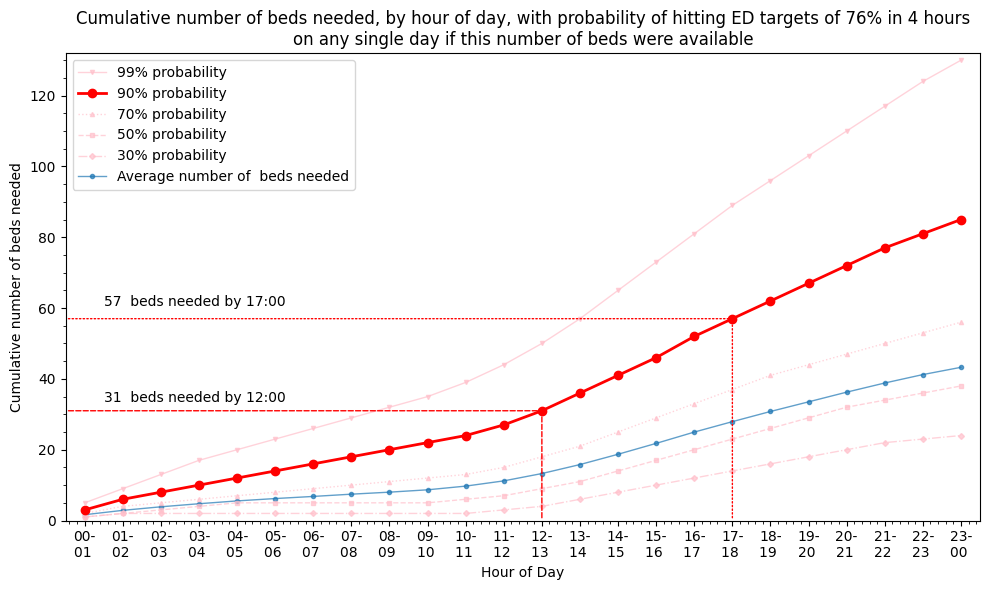

In [66]:
title = f'Cumulative number of beds needed, by hour of day, with probability of hitting ED targets of {int(y1*100)}% in {int(x1)} hours\non any single day if this number of beds were available'

plot_final(poisson_means_sum, title)

## Plot by specialty

In [67]:
hours, arrival_rates, arrival_rates_lagged = get_arrival_rates(train_yta, time_interval = 60)

hour_labels = [f'{hour.strftime("%H")}-\n{str((hour.hour + 1) % 24).zfill(2)} 'for hour in hours]
hour_values = list(range(len(hour_labels)))

# Calculate a tiny margin for the x-axis
x_margin = 0.5  # Adjust this value as needed for a tiny margin

line_styles = {12: '--', 17 : ':'}

Calculating time-varying arrival rates for data provided, which spans 130 unique dates


Calculating time-varying arrival rates for data provided, which spans 130 unique dates


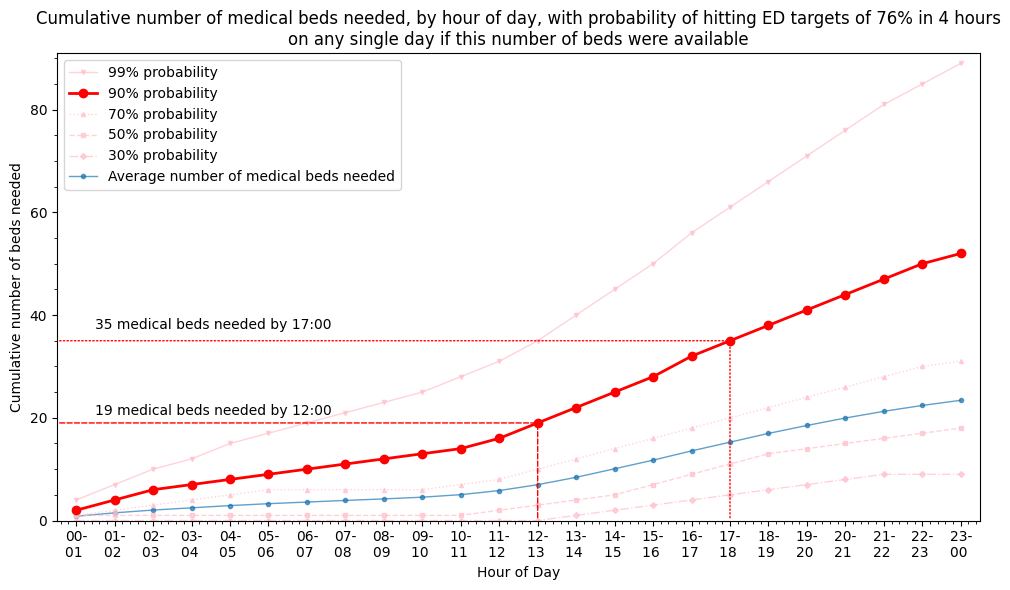

Calculating time-varying arrival rates for data provided, which spans 130 unique dates


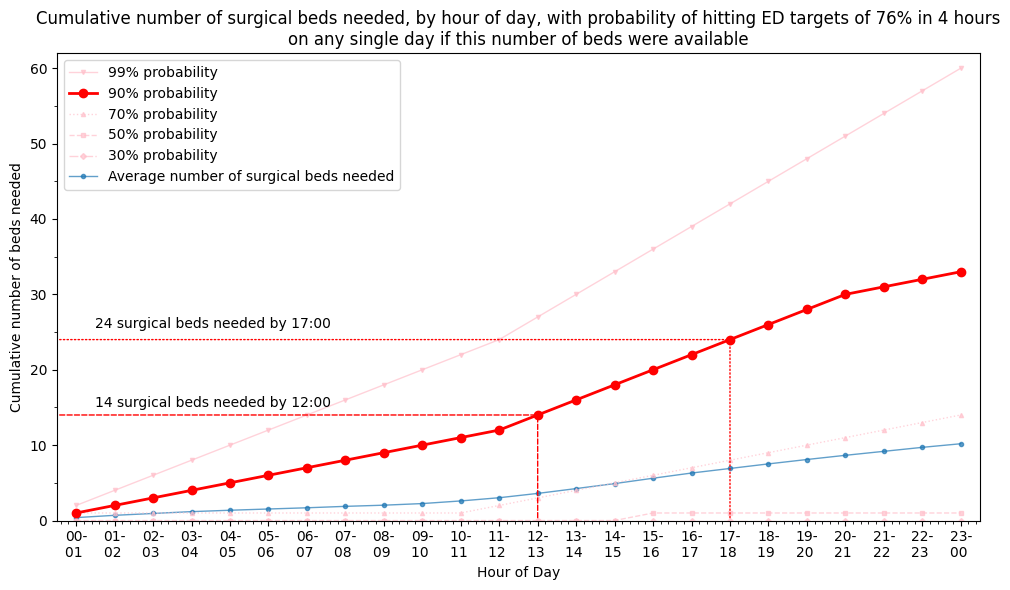

Calculating time-varying arrival rates for data provided, which spans 130 unique dates


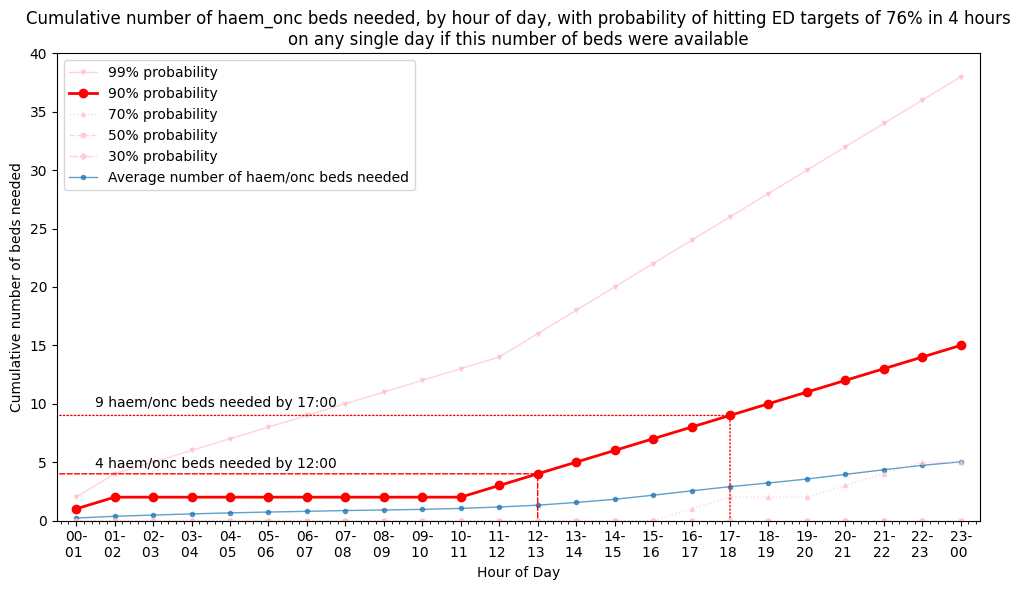

Calculating time-varying arrival rates for data provided, which spans 126 unique dates


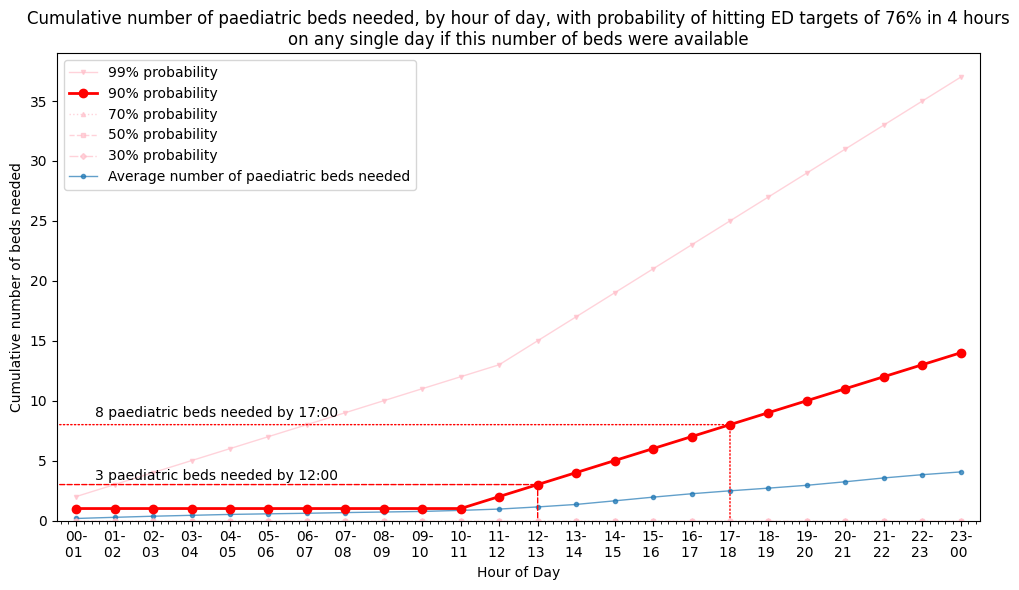

In [69]:
for _spec in ['medical', 'surgical', 'haem/onc', 'paediatric']:
    train_yta_spec = train_yta[(~train_yta.specialty.isnull()) & (train_yta.specialty == _spec)]
    poisson_means_sum_spec = get_true_demand_by_hour(train_yta_spec)
    __spec = _spec.replace('/', '_')
    
    title = f'Cumulative number of {__spec} beds needed, by hour of day, with probability of hitting ED targets of {int(y1*100)}% in {int(x1)} hours\non any single day if this number of beds were available'
    
    plot_final(poisson_means_sum_spec, title, _spec = _spec)